# Taxi Orders Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
%matplotlib inline

## Data Analyses & Preparation

In [2]:
df = pd.read_csv("taxi.csv",parse_dates=[0], index_col = [0])

In [3]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
df.shape

(26496, 1)

In [5]:
df.isnull().sum()

num_orders    0
dtype: int64

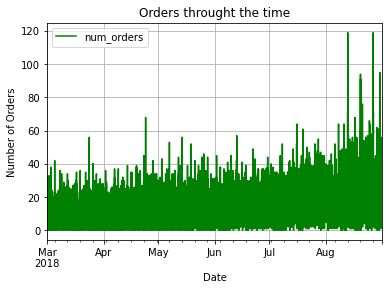

In [6]:
df.plot(color="g")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.title("Orders throught the time")
plt.grid()
plt.show()

I believe that it would be of more use if the data was taken hourly for the predictions sector.

In [7]:
df = df.resample("1H").sum()

In [11]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


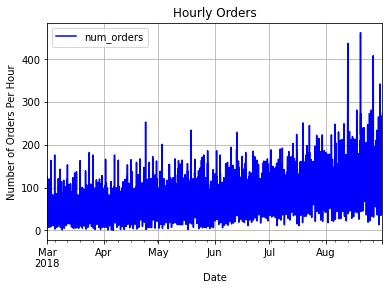

In [8]:
df.plot(color = "b")
plt.xlabel("Date")
plt.ylabel("Number of Orders Per Hour")
plt.title("Hourly Orders")
plt.grid()
plt.show()

In [9]:
df_daily = df.resample("1D").sum()

In [10]:
df_daily.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


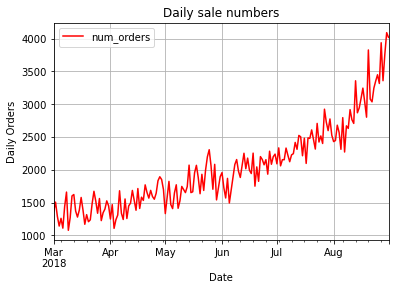

In [12]:
df_daily.plot(color = "r")
plt.grid()
plt.xlabel("Date")
plt.ylabel("Daily Orders")
plt.title("Daily sale numbers")
plt.show()

I've done this just to test the daily data, however I will not be using this later on.

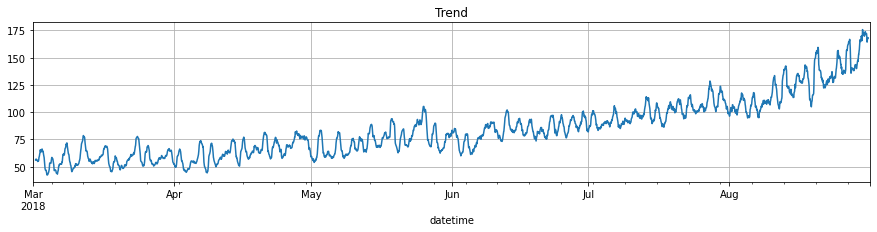

In [13]:
deco =  seasonal_decompose(df)

plt.figure(figsize=(8,8))
plt.subplot(311)
deco.trend.plot(ax = plt.gca(), figsize = (15,10))
plt.title("Trend")
plt.grid()
plt.show()

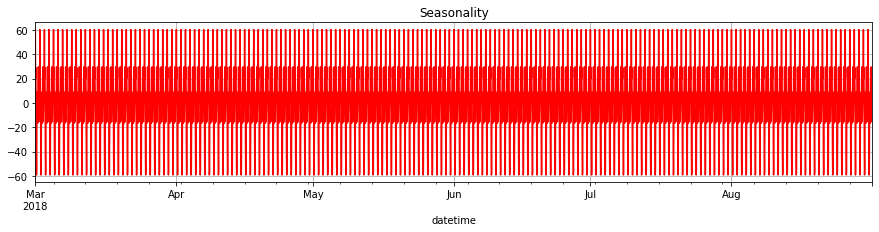

In [14]:
plt.subplot(312)
deco.seasonal.plot(ax = plt.gca(), figsize = (15,10),color="r")
plt.title("Seasonality")
plt.grid()
plt.show()

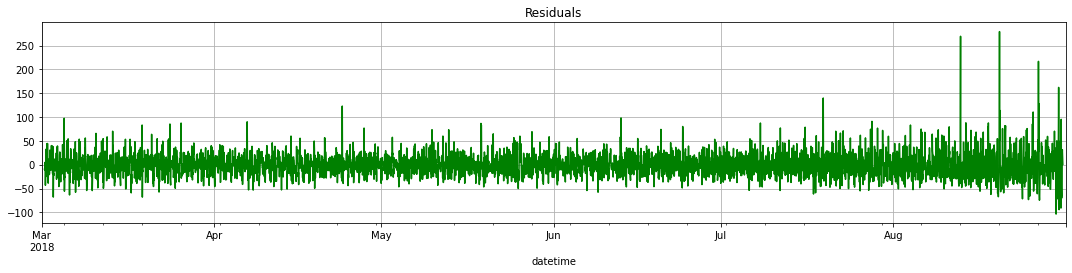

In [16]:
plt.subplot(313)
deco.resid.plot(ax = plt.gca(),figsize = (15,10),color = "g")
plt.title("Residuals")
plt.tight_layout()
plt.grid()
plt.show()

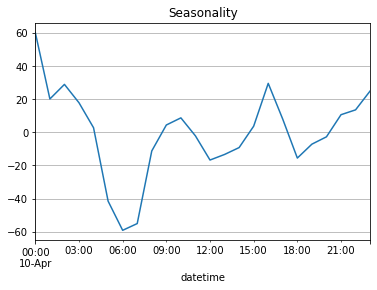

In [17]:
deco.seasonal['10 April 2018'].plot(ax=plt.gca())
plt.title("Seasonality")
plt.grid()
plt.show()

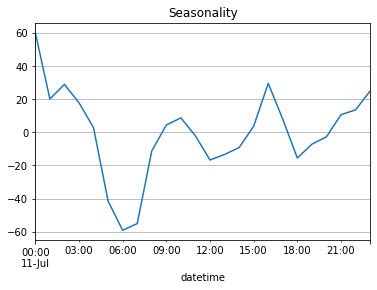

In [18]:
deco.seasonal['11 July 2018'].plot(ax=plt.gca())
plt.title("Seasonality")
plt.grid()
plt.show()

In all the graphs plotted above there seems to exist some sort of pattern, that would mean that predictions could be made from it, for example in the seasonality graph, between different dates a pattern is clearly visible.

## Training The Model 

In [19]:
df["Hour"] = df.index.hour
df["Day"] = df.index.day
df["DayofWeek"] = df.index.dayofweek
df["Month"] = df.index.month

df.head()

,num_orders,Hour,Day,DayofWeek,Month
datetime,,,,,
2018-03-01 00:00:00,124,0,1,3,3
2018-03-01 01:00:00,85,1,1,3,3
2018-03-01 02:00:00,71,2,1,3,3
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,4,1,3,3


In [20]:
for lag in range(1,6):
    df['lag_{}'.format(lag)] = df["num_orders"].shift(lag)
df["Rolling_Mean"] = df["num_orders"].shift().rolling(10).mean()
df.head()

,num_orders,Hour,Day,DayofWeek,Month,lag_1,lag_2,lag_3,lag_4,lag_5,Rolling_Mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,3,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,3,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,3,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,3,66.0,71.0,85.0,124.0,NaN,NaN


In [21]:
df.dropna(inplace = True)
df.shape

(4406, 11)

In [22]:
train_val, test = train_test_split(df,shuffle = False, test_size = 0.1)
train, val = train_test_split(train_val, shuffle = False, test_size = 0.1)


In [23]:
features_train = train.drop(["num_orders"],axis = 1)
target_train = train["num_orders"]
features_valid = val.drop(["num_orders"],axis = 1)
target_valid = val["num_orders"]
features_test = test.drop(["num_orders"],axis = 1)
target_test = test["num_orders"]

In [24]:
def rmse_metric(true,pred):
    return mean_squared_error(true,pred) ** 0.5

lr = LinearRegression()
lr.fit(features_train,target_train)

pred_train = lr.predict(features_train)
pred_val = lr.predict(features_valid)

print("RMSE Train: ", rmse_metric(target_train,pred_train))
print("RMSE Valid: ", rmse_metric(target_valid,pred_val))

RMSE Train:  29.18903228633541
RMSE Valid:  40.53908230514034


In [25]:
for i in range(10,50,5):
    rf = RandomForestRegressor(n_estimators = i, random_state = 12345)
    rf.fit(features_train,target_train)
    pred_train = rf.predict(features_train)
    pred_val = rf.predict(features_valid)
    print("Estimators: ",i," RMSE Train: ", rmse_metric(target_train,pred_train))
    print("Estimators: ",i," RMSE Valid: ", rmse_metric(target_valid,pred_val))

Estimators:  10  RMSE Train:  9.501657278148382
Estimators:  10  RMSE Valid:  32.87592773877474
Estimators:  15  RMSE Train:  8.955761771553503
Estimators:  15  RMSE Valid:  32.94666070668229
Estimators:  20  RMSE Train:  8.742684121287859
Estimators:  20  RMSE Valid:  32.79073283642228
Estimators:  25  RMSE Train:  8.557665407091523
Estimators:  25  RMSE Valid:  32.79517854838042
Estimators:  30  RMSE Train:  8.406457904744137
Estimators:  30  RMSE Valid:  32.51555131819063
Estimators:  35  RMSE Train:  8.289310517033861
Estimators:  35  RMSE Valid:  32.663332995374645
Estimators:  40  RMSE Train:  8.24635019568584
Estimators:  40  RMSE Valid:  32.506137499339175
Estimators:  45  RMSE Train:  8.223302104579602
Estimators:  45  RMSE Valid:  32.39345260035903


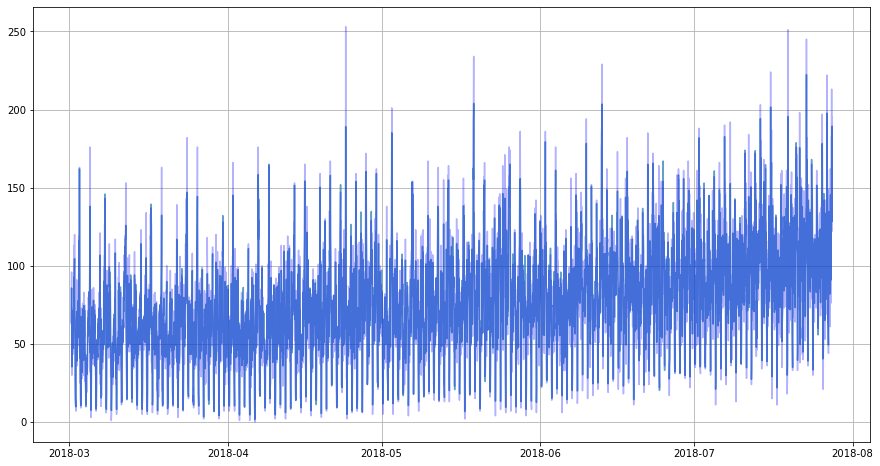

In [26]:
plt.figure(figsize=(15,8))
plt.plot(features_train.index,pred_train,alpha = 0.7)
plt.plot(features_train.index,target_train,color="b",alpha=0.3)
plt.grid()
plt.show()

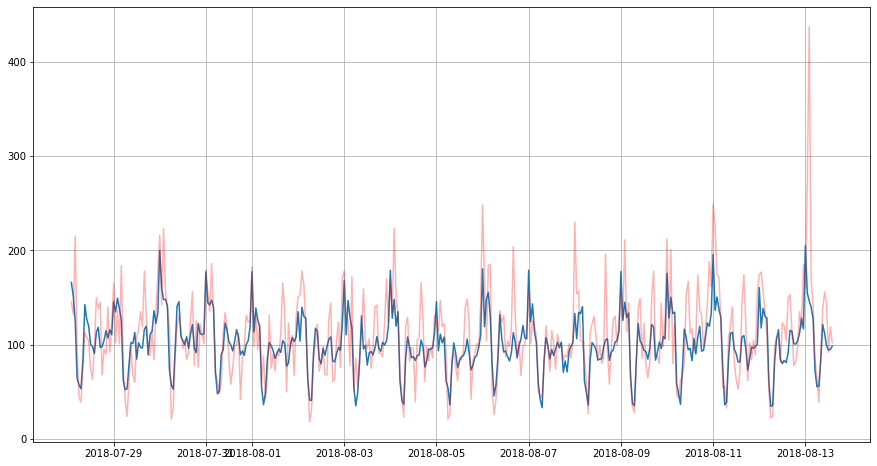

In [27]:
plt.figure(figsize=(15,8))
plt.plot(features_valid.index,pred_val)
plt.plot(features_valid.index,target_valid,color="red",alpha=0.3)
plt.grid()
plt.show()

In [29]:
model = RandomForestRegressor()
params = {"n_estimators": [10,25,50]}

tscv = TimeSeriesSplit()
gs = GridSearchCV(estimator = model, cv= tscv, param_grid = params)
gs.fit(features_train,target_train)
gs.cv_results_

{'mean_fit_time': array([0.07067428, 0.1613523 , 0.32831135]),
 'std_fit_time': array([0.02350797, 0.07366323, 0.13627237]),
 'mean_score_time': array([0.00339174, 0.00499463, 0.00728431]),
 'std_score_time': array([0.00101651, 0.0010906 , 0.00059913]),
 'param_n_estimators': masked_array(data=[10, 25, 50],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10}, {'n_estimators': 25}, {'n_estimators': 50}],
 'split0_test_score': array([0.34399394, 0.33991693, 0.35185972]),
 'split1_test_score': array([0.43833398, 0.47183578, 0.47659057]),
 'split2_test_score': array([0.4801754 , 0.54459598, 0.5645706 ]),
 'split3_test_score': array([0.30556847, 0.42727253, 0.41221996]),
 'split4_test_score': array([0.40673337, 0.44307083, 0.4357894 ]),
 'mean_test_score': array([0.39496103, 0.44533841, 0.44820605]),
 'std_test_score': array([0.06303961, 0.06633156, 0.07082115]),
 'rank_test_score': array([3, 2, 1])}

## Testing

In [30]:
features_train_valid = train_val.drop(["num_orders"],axis=1)
target_train_valid = train_val["num_orders"]

model = RandomForestRegressor(n_estimators = 45,random_state = 12345)
model.fit(features_train_valid,target_train_valid)
pred_train = model.predict(features_train_valid)
pred_test = model.predict(features_test)
print("Estimators: ",i," RMSE Train: ", rmse_metric(target_train_valid,pred_train))
print("Estimators: ",i," RMSE Valid: ", rmse_metric(target_test,pred_test))

Estimators:  45  RMSE Train:  8.707539114610533
Estimators:  45  RMSE Valid:  47.32345930886097


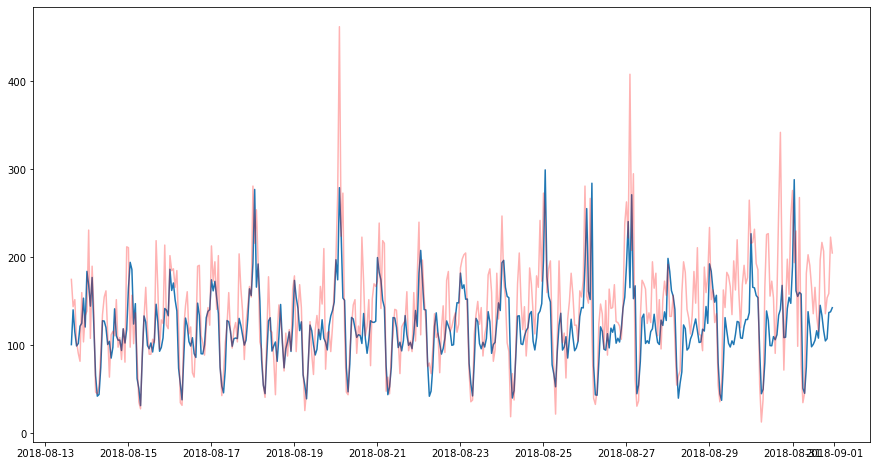

In [31]:
plt.figure(figsize=(15,8))
plt.plot(features_test.index,pred_test)
plt.plot(features_test.index,target_test, color="r", alpha = 0.3)
plt.show()

In [32]:
tscv = TimeSeriesSplit()
print(tscv)

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [33]:
for train_index, test_index in tscv.split(train_val):
    print("Train Indices: ", train_index[0]," ",train_index[-1])
    print("Train Time Range: ", train_val.iloc[train_index].index[0]," ",train_val.iloc[train_index].index[-1])
    print("Test Indices: ", test_index[0]," ",test_index[-1])
    print("Test Time Range: ", train_val.iloc[test_index].index[0], " ", train_val.iloc[test_index].index[-1])
    train, valid = train_val.iloc[train_index],train_val.iloc[test_index]

Train Indices:  0   664
Train Time Range:  2018-03-01 10:00:00   2018-03-29 02:00:00
Test Indices:  665   1324
Test Time Range:  2018-03-29 03:00:00   2018-04-25 14:00:00
Train Indices:  0   1324
Train Time Range:  2018-03-01 10:00:00   2018-04-25 14:00:00
Test Indices:  1325   1984
Test Time Range:  2018-04-25 15:00:00   2018-05-23 02:00:00
Train Indices:  0   1984
Train Time Range:  2018-03-01 10:00:00   2018-05-23 02:00:00
Test Indices:  1985   2644
Test Time Range:  2018-05-23 03:00:00   2018-06-19 14:00:00
Train Indices:  0   2644
Train Time Range:  2018-03-01 10:00:00   2018-06-19 14:00:00
Test Indices:  2645   3304
Test Time Range:  2018-06-19 15:00:00   2018-07-17 02:00:00
Train Indices:  0   3304
Train Time Range:  2018-03-01 10:00:00   2018-07-17 02:00:00
Test Indices:  3305   3964
Test Time Range:  2018-07-17 03:00:00   2018-08-13 14:00:00


In [34]:
model = RandomForestRegressor(n_estimators = 25)
model.fit(features_train_valid,target_train_valid)
pred_train = model.predict(features_train_valid)
pred_test = model.predict(features_test)
print("Estimators: ",i," RMSE Train: ", rmse_metric(target_train_valid,pred_train))
print("Estimators: ",i," RMSE Valid: ", rmse_metric(target_test,pred_test))

Estimators:  45  RMSE Train:  9.070196528706358
Estimators:  45  RMSE Valid:  45.714040554898176


# Conclusion

The first step in this project was to obtain the data, after doing so we inspected the data in order to detect what issues there were, I didn't find issues and so i resampled the data into hours,I have done so in order to meet the standards of the project, after doing so I graphed the information and I also graphed the daily orders just for some insights. After so i decomposed the data into trend, seasonality and residuals and there was an obvious pattern in so which I learned by graphing the seasonality information and checking different dates. After that I moved to the training the data part, training the data could only be done after creating columns representing hour,day, day of the week (numerical) and month, and after that i rolled the data and created a rolling mean columns, after doing so I dropped the NAN data (which was a minute percentage of the total data), after that I splitted the data and trained a linear regression model, that model gave me a RMSE of 40.5 which is well below of my personald treshhold of 48 so I after that i tried to use a Random Forest Regressor model with hypterparameter tuning of which game me a better value for the RMSE, considering the difference between the RMSE score between train and valid it seems clear that there is an overfitting issue, although I can't tell if it's due to the quality of the data or the quantity. When doing the testing it was even clearer that there was an overfitting issue and that the valid score jumped to the 40s area, however my random forest classifier model managed to obtain a metric under the 48 threshhold (it got 45).